## Transfer Learning Tuning_beard:
  * model parameter and other information can be found below:
     * [source](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
     
  * base_model: use vgg16 and freeze at bottleneck layer (stop right before flatten layer) 
  * top_model: tune dense layers (parameters are inspired by source)
     * batch_size 16 seems to work best for small data set 

##### warnings: make sure to restart kernel in between running different model tuning 
  
---
#### This cell is required in order to use GPU for running the model 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
keras.backend.get_session().run(tf.global_variables_initializer())  

W0829 13:30:32.548914 140667119040320 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0829 13:30:32.549813 140667119040320 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



---
#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16
from keras import optimizers
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


---
#### Import train_df and test_df

In [3]:
train_df = pd.read_pickle('../pickle_files/train_df_beard.pkl')
test_df = pd.read_pickle('../pickle_files/test_df_beard.pkl')

#### Get bottleneck features to tune top models

In [4]:
def save_bottleneck_features(train_df, test_df, label, batch_size):
    '''
    inputs:
    train_df, test_df: train and test dataframes saved in pickle_files folder
    label: a string, eyewear, hat, or beard
    batch_size: process images in batches
    outputs:
    saves bottleneck features inside folder tuning_data as npy file
    '''
    # intialize the vgg16 model 
    # make sure not to train the top layers 
    base_model = VGG16(weights = 'imagenet', include_top = False)
    # create train_generator and test_generator to get bottleneck inputs for train and test df 
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    # make sure shuffle is False so we know the label follows the sequence of the dataframe 
    # so we can tune top_model 
    train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    shuffle = False,
    target_size=(150,150),
    class_mode = None)
    # get features saved as .npy in tunign_data folder 
    bottleneck_features_train = base_model.predict_generator(
        train_generator, train_df.shape[0]//batch_size)
    np.save(open('../tuning_data/bottleneck_features_train_beard.npy','wb'),
           bottleneck_features_train)
    
    test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    shuffle = False,
    target_size=(150,150),
    class_mode = None)
    bottleneck_features_test = base_model.predict_generator(
        test_generator, test_df.shape[0]//batch_size)
    np.save(open('../tuning_data/bottleneck_features_test_beard.npy','wb'),
           bottleneck_features_test)

#### Save bottleneck_features

In [5]:
save_bottleneck_features(train_df,test_df,'beard',16)

W0829 13:31:41.025565 140667119040320 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 13:31:41.026250 140667119040320 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 13:31:41.028058 140667119040320 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 13:31:41.043291 140667119040320 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Found 363 validated image filenames.
Found 91 validated image filenames.


### Quick tuning of top models 

In [6]:
def train_top_model(train_df, test_df, epoch, batch_size, label):
    '''
    inputs:
    train_df, test_df: dataframes saved in pickle_files to generate train and test labels 
    epoch: num of epochs in fit 
    batch_size: same as image generator batch size 
    label: a string, eyewear, hat, or beard
    output:
    saves model weights in a folder 
    '''
    train_data = np.load(open('../tuning_data/bottleneck_features_train_beard.npy','rb'))
    # make sure train_data and train_label have same num of samples
    train_label = np.array(train_df[label].map({'not_'+label:0, label:1}))[:-(train_df.shape[0]%batch_size)]
    
    test_data = np.load(open('../tuning_data/bottleneck_features_test_beard.npy','rb'))
    test_label = np.array(test_df[label].map({'not_'+label:0, label:1}))[:-(test_df.shape[0]%batch_size)]
    
    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
     # checkpoint for best weights 
    filepath="../tuning_data/best_bottleneck_vgg_model_beard.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    model.fit(train_data, train_label,
             epochs=epoch,
             batch_size=batch_size,
             validation_data=(test_data,test_label),
             callbacks=callbacks_list)
    del model
    keras.backend.clear_session()

#### run train_top_model and save results in tuning_data

In [7]:
train_top_model(train_df, test_df, 50, 16, 'beard')

W0829 13:33:32.124638 140667119040320 deprecation.py:506] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0829 13:33:32.136728 140667119040320 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0829 13:33:32.147027 140667119040320 deprecation.py:323] From /home/mindy/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as n

Train on 352 samples, validate on 80 samples
Epoch 1/50
352/352 [==============================] - 0s 1ms/step - loss: 2.2591 - acc: 0.5625 - val_loss: 0.5306 - val_acc: 0.8000

Epoch 00001: val_acc improved from -inf to 0.80000, saving model to ../tuning_data/best_bottleneck_vgg_model_beard.h5
Epoch 2/50
352/352 [==============================] - 0s 191us/step - loss: 0.6313 - acc: 0.7699 - val_loss: 1.0175 - val_acc: 0.5875

Epoch 00002: val_acc did not improve from 0.80000
Epoch 3/50
352/352 [==============================] - 0s 189us/step - loss: 0.3825 - acc: 0.8267 - val_loss: 0.6781 - val_acc: 0.7750

Epoch 00003: val_acc did not improve from 0.80000
Epoch 4/50
352/352 [==============================] - 0s 193us/step - loss: 0.5254 - acc: 0.8125 - val_loss: 0.6865 - val_acc: 0.7750

Epoch 00004: val_acc did not improve from 0.80000
Epoch 5/50
352/352 [==============================] - 0s 194us/step - loss: 0.3343 - acc: 0.8750 - val_loss: 0.7847 - val_acc: 0.7000

Epoch 00005: v

352/352 [==============================] - 0s 186us/step - loss: 6.2418e-04 - acc: 1.0000 - val_loss: 0.8473 - val_acc: 0.8875

Epoch 00043: val_acc did not improve from 0.91250
Epoch 44/50
352/352 [==============================] - 0s 194us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 1.1180 - val_acc: 0.9125

Epoch 00044: val_acc did not improve from 0.91250
Epoch 45/50
352/352 [==============================] - 0s 191us/step - loss: 1.3537e-04 - acc: 1.0000 - val_loss: 1.1606 - val_acc: 0.9125

Epoch 00045: val_acc did not improve from 0.91250
Epoch 46/50
352/352 [==============================] - 0s 189us/step - loss: 5.5047e-04 - acc: 1.0000 - val_loss: 0.9638 - val_acc: 0.8875

Epoch 00046: val_acc did not improve from 0.91250
Epoch 47/50
352/352 [==============================] - 0s 189us/step - loss: 0.0224 - acc: 0.9943 - val_loss: 0.9294 - val_acc: 0.8875

Epoch 00047: val_acc did not improve from 0.91250
Epoch 48/50
352/352 [==============================] - 0s 193us/step -

### Fine Tune Top Model to improve accuracy

In [8]:
def fine_tune_model(train_df, test_df,epoch, batch_size,label, print_model = True):
    # build VGG16 model and freeze top layers
    # input_shape: width, height, RGB (from image generator)
    model_vgg = VGG16(weights='imagenet',include_top=False, input_shape=(150,150,3))
    # build top model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
    top_model.add(Dense(256,activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    
    # load saved weights to fine tune parameters 
    top_model.load_weights('../tuning_data/best_bottleneck_vgg_model_beard.h5')
    # add top model to model
    model = Model(inputs=model_vgg.input, outputs=top_model(model_vgg.output))
    # we will tune last 5 layers of the model: block5 and fully connected layer 
    for layer in model.layers[:15]:
        layer.trainable = False
    # we can tune the parameters for lr and momentum later to get better results
    model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
             metrics=['accuracy'])
    # prepare train generator using data augmentation to battle small sample size 
    train_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    # not want to augment the test 
    test_gen = ImageDataGenerator(rescale=1./255)
    
    train_generator =  train_gen.flow_from_dataframe(
    dataframe=train_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    target_size=(150,150),
    class_mode = 'binary')
    
    test_generator =  test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    target_size=(150,150),
    class_mode = 'binary')
    
    # checkpoint for best weights 
    filepath="../tuning_data/best_vgg_model_beard.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    # run and fit model 
    result = model.fit_generator(
    train_generator,
    steps_per_epoch=train_df.shape[0]//batch_size,
    epochs=epoch,
    validation_data=test_generator,
    validation_steps=test_df.shape[0]//batch_size,
    verbose=1,
    callbacks=callbacks_list)

    if print_model:
        model.summary()
        
    del model
    keras.backend.clear_session()
    return result

### save model history 

In [9]:
model_history = fine_tune_model(train_df, test_df,50,16,'beard')

Found 363 validated image filenames belonging to 2 classes.
Found 91 validated image filenames belonging to 2 classes.
Epoch 1/50
22/22 [==============================] - 3s 152ms/step - loss: 4.1282 - acc: 0.3246 - val_loss: 0.6967 - val_acc: 0.5375

Epoch 00001: val_acc improved from -inf to 0.53750, saving model to ../tuning_data/best_vgg_model_beard.h5
Epoch 2/50
22/22 [==============================] - 3s 137ms/step - loss: 0.7177 - acc: 0.5427 - val_loss: 0.6312 - val_acc: 0.6933

Epoch 00002: val_acc improved from 0.53750 to 0.69333, saving model to ../tuning_data/best_vgg_model_beard.h5
Epoch 3/50
22/22 [==============================] - 3s 138ms/step - loss: 0.6635 - acc: 0.5873 - val_loss: 0.6622 - val_acc: 0.5733

Epoch 00003: val_acc did not improve from 0.69333
Epoch 4/50
22/22 [==============================] - 3s 122ms/step - loss: 0.6169 - acc: 0.6410 - val_loss: 0.5871 - val_acc: 0.7467

Epoch 00004: val_acc improved from 0.69333 to 0.74667, saving model to ../tuning_d

22/22 [==============================] - 3s 121ms/step - loss: 0.1290 - acc: 0.9508 - val_loss: 0.1583 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 0.94667
Epoch 43/50
22/22 [==============================] - 3s 134ms/step - loss: 0.0594 - acc: 0.9886 - val_loss: 0.2060 - val_acc: 0.9250

Epoch 00043: val_acc did not improve from 0.94667
Epoch 44/50
22/22 [==============================] - 3s 143ms/step - loss: 0.1068 - acc: 0.9545 - val_loss: 0.2118 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 0.94667
Epoch 45/50
22/22 [==============================] - 3s 131ms/step - loss: 0.0794 - acc: 0.9744 - val_loss: 0.0706 - val_acc: 0.9600

Epoch 00045: val_acc improved from 0.94667 to 0.96000, saving model to ../tuning_data/best_vgg_model_beard.h5
Epoch 46/50
22/22 [==============================] - 3s 118ms/step - loss: 0.0545 - acc: 0.9829 - val_loss: 0.2557 - val_acc: 0.9333

Epoch 00046: val_acc did not improve from 0.96000
Epoch 47/50
22/22 [=============

In [10]:
highest_val_acc, highest_train_acc = max(model_history.history['val_acc']), max(model_history.history['acc'])
print(f'highest test accuracy: {highest_val_acc}')
print('------------------')
print(f'highest train accuracy: {highest_train_acc}')

highest test accuracy: 0.9600000039736429
------------------
highest train accuracy: 0.9886363636363636


In [11]:
lowest_val_loss, lowest_train_loss = min(model_history.history['val_loss']), min(model_history.history['loss'])
print(f'lowest test loss: {lowest_val_loss}')
print('------------------')
print(f'lowest train loss: {lowest_train_loss}')

lowest test loss: 0.07060661147038141
------------------
lowest train loss: 0.05498526646334259


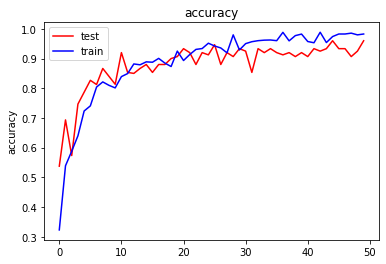

In [12]:
plt.plot(model_history.history['val_acc'], color = 'red', label = 'test')
plt.plot(model_history.history['acc'], color = 'blue', label = 'train')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.legend()
plt.show()

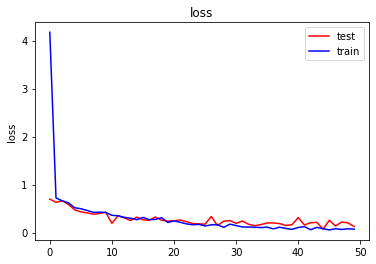

In [13]:
plt.plot(model_history.history['val_loss'], color = 'red', label = 'test')
plt.plot(model_history.history['loss'], color = 'blue', label = 'train')
plt.title('loss')
plt.ylabel('loss')
plt.legend()
plt.show()

### Save model 

In [14]:
# save model artchitecture 
beard_model = model_history.model
beard_model_json = beard_model.to_json()

In [15]:
# serialize model to JSON
with open("beard_model.json", "w") as json_file:
    json_file.write(beard_model_json)

In [16]:
# load json and create model
json_file = open('beard_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_beard = model_from_json(loaded_model_json)

In [18]:
# load model weight 
loaded_model_beard.load_weights('../tuning_data/best_vgg_model_beard.h5')

In [19]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator =  test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col='beard',
    batch_size=16,
    target_size=(150,150),
    class_mode = 'binary')

Found 91 validated image filenames belonging to 2 classes.


In [20]:
loaded_model_beard.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
             metrics=['accuracy'])

In [21]:
loaded_model_beard.evaluate_generator(test_generator)

[0.167782618531159, 0.945054945054945]